# Libraries

In [ ]:
import os
import warnings
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import joblib
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder


# Data Collection and Dataset generator

> Add blockquote



In [ ]:
os.makedirs("data", exist_ok=True)

R = 1000
np.random.seed(42)
random.seed(42)


In [ ]:
ages = np.random.randint(18, 71, size=R)
genders = np.random.choice(['Male','Female'], size=R, p=[0.5,0.5])
monthly_usage = np.random.randint(5, 201, size=R)
num_transactions = np.random.randint(1, 51, size=R)
subscription_type = np.random.choice(['Basic','Premium','Gold'], size=R, p=[0.6,0.3,0.1])
complaints = np.random.randint(0, 11, size=R)


In [ ]:
prob = (
    0.02*(ages - 18) +
    0.3*(subscription_type == 'Basic').astype(int) +
    -0.002*monthly_usage +
    0.02*(num_transactions < 5) +
    0.05*complaints
)


In [ ]:
prob = prob - prob.min()
prob = prob / (prob.max() + 1e-8)


In [ ]:
churn = np.random.binomial(
    1,
    p=np.clip(prob * 0.20 + 0.03, 0.01, 0.20)
)


In [ ]:
df = pd.DataFrame({
    'Age': ages,
    'Gender': genders,
    'MonthlyUsageHours': monthly_usage,
    'NumTransactions': num_transactions,
    'SubscriptionType': subscription_type,
    'Complaints': complaints,
    'Churn': churn
})


In [ ]:
def add_missing_values(series, missing_rate=0.08):
    mask = np.random.rand(len(series)) < missing_rate
    series[mask] = np.nan
    return series


In [ ]:
for col in ['Age', 'Gender', 'MonthlyUsageHours', 'NumTransactions', 'SubscriptionType', 'Complaints']:
    df[col] = add_missing_values(df[col])


/tmp/ipython-input-2530234012.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series[mask] = np.nan
/tmp/ipython-input-2530234012.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series[mask] = np.nan
/tmp/ipython-input-2530234012.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series[mask] = np.nan
/tmp/ipython-input-2530234012.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame


In [ ]:
df.to_csv('data/customer_churn_data.csv', index=False)
print("Saved data/customer_churn_data.csv with low churn rate!")


Saved data/customer_churn_data.csv with low churn rate!


In [ ]:
df.head()

,Age,Gender,MonthlyUsageHours,NumTransactions,SubscriptionType,Complaints,Churn
0,NaN,Female,154.0,24.0,Basic,9.0,0
1,69.0,Female,48.0,34.0,Basic,3.0,0
2,46.0,Male,190.0,27.0,Basic,5.0,1
3,32.0,Female,40.0,41.0,Premium,7.0,0
4,60.0,Female,NaN,1.0,Basic,10.0,0


In [ ]:
df['Churn'].value_counts()

,count
Churn,
0,872
1,128


# Preprocessing & Feature Engineering

In [ ]:
df.head()

,Age,Gender,MonthlyUsageHours,NumTransactions,SubscriptionType,Complaints,Churn
0,NaN,Female,154.0,24.0,Basic,9.0,0
1,69.0,Female,48.0,34.0,Basic,3.0,0
2,46.0,Male,190.0,27.0,Basic,5.0,1
3,32.0,Female,40.0,41.0,Premium,7.0,0
4,60.0,Female,NaN,1.0,Basic,10.0,0


In [ ]:
df.describe()

,Age,MonthlyUsageHours,NumTransactions,Complaints,Churn
count,924.000000,913.000000,923.000000,923.000000,1000.000000
mean,44.372294,105.481928,26.293608,5.150596,0.128000
std,15.354882,56.582826,14.248090,3.137152,0.334257
min,18.000000,5.000000,1.000000,0.000000,0.000000
25%,31.000000,57.000000,14.000000,2.000000,0.000000
50%,45.000000,111.000000,27.000000,5.000000,0.000000
75%,57.000000,154.000000,38.000000,8.000000,0.000000
max,70.000000,200.000000,50.000000,10.000000,1.000000


In [ ]:
categorical_cols = ["Gender", "SubscriptionType"]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                924 non-null    float64
 1   Gender             919 non-null    object 
 2   MonthlyUsageHours  913 non-null    float64
 3   NumTransactions    923 non-null    float64
 4   SubscriptionType   926 non-null    object 
 5   Complaints         923 non-null    float64
 6   Churn              1000 non-null   int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 54.8+ KB


In [ ]:
df["Age"].fillna(df["Age"].mean(), inplace=True)

/tmp/ipython-input-1809399462.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Age"].fillna(df["Age"].mean(), inplace=True)


In [ ]:
df["Gender"].fillna(df["Gender"].mode()[0], inplace=True)
df = pd.get_dummies(df, columns=["Gender"], drop_first=True)


/tmp/ipython-input-450980026.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Gender"].fillna(df["Gender"].mode()[0], inplace=True)


In [ ]:
df["MonthlyUsageHours"].fillna(df["MonthlyUsageHours"].mean(), inplace=True)
df["NumTransactions"].fillna(df["NumTransactions"].mean(), inplace=True)
df["SubscriptionType"].fillna(df["SubscriptionType"].mode()[0], inplace=True)
label_map = {"Basic": 1, "Premium": 2, "Gold": 3}
df["SubscriptionType"] = df["SubscriptionType"].map(label_map)
df["Complaints"].fillna(df["Complaints"].median(), inplace=True)


/tmp/ipython-input-4205771900.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["MonthlyUsageHours"].fillna(df["MonthlyUsageHours"].mean(), inplace=True)
/tmp/ipython-input-4205771900.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(v

In [ ]:
df.head()

,Age,MonthlyUsageHours,NumTransactions,SubscriptionType,Complaints,Churn,Gender_Male
0,44.372294,154.000000,24.0,1,9.0,0,False
1,69.000000,48.000000,34.0,1,3.0,0,False
2,46.000000,190.000000,27.0,1,5.0,1,True
3,32.000000,40.000000,41.0,2,7.0,0,False
4,60.000000,105.481928,1.0,1,10.0,0,False


In [ ]:
df.value_counts('Churn')

,count
Churn,
0,872
1,128


In [ ]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

In [ ]:
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

In [ ]:
print("Before SMOTE:")
print(y.value_counts())
print("\nAfter SMOTE:")
print(y_resampled.value_counts())

Before SMOTE:
Churn
0    872
1    128
Name: count, dtype: int64

After SMOTE:
Churn
0    872
1    872
Name: count, dtype: int64


In [ ]:
X_resampled.head()

,Age,MonthlyUsageHours,NumTransactions,SubscriptionType,Complaints,Gender_Male
0,44.372294,154.000000,24.0,1,9.0,False
1,69.000000,48.000000,34.0,1,3.0,False
2,46.000000,190.000000,27.0,1,5.0,True
3,32.000000,40.000000,41.0,2,7.0,False
4,60.000000,105.481928,1.0,1,10.0,False


# Standardizing the SMOTE-Balanced Dataset

In [ ]:
X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
scaler = StandardScaler()


In [ ]:
numeric_cols = X_resampled.select_dtypes(include=['float64', 'int64']).columns
X_resampled[numeric_cols] = scaler.fit_transform(X_resampled[numeric_cols])
print(X_resampled.head())

        Age  MonthlyUsageHours  NumTransactions  SubscriptionType  Complaints  \
0 -0.109513           0.887380        -0.139901         -0.567216    1.292306   
1  1.624098          -1.076027         0.609118         -0.567216   -0.855709   
2  0.005066           1.554197         0.084805         -0.567216   -0.139704   
3 -0.980432          -1.224209         1.133431          1.192971    0.576301   
4  0.990564          -0.011306        -1.862645         -0.567216    1.650309   

   Gender_Male  
0        False  
1        False  
2         True  
3        False  
4        False  


In [60]:
scaler.var_

array([2.01810895e+02, 2.91468241e+03, 1.78243696e+02, 3.22761920e-01,
       7.80239462e+00])

# Model Training

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.20, random_state=42, stratify=y_resampled
)

In [ ]:
columns = X_train.columns.tolist()
# joblib.dump(columns, "columns.joblib")
columns

['Age',
 'MonthlyUsageHours',
 'NumTransactions',
 'SubscriptionType',
 'Complaints',
 'Gender_Male']

In [ ]:
X_train.shape

(1395, 6)

In [ ]:
y_train.shape

(1395,)

In [ ]:
# 2. LOGISTIC REGRESSION  (Surface-level features)
log_model = LogisticRegression(max_iter=2000)
log_model.fit(X_train, y_train)

log_pred = log_model.predict(X_test)

In [ ]:
print("\n==== Logistic Regression ====")
print("Accuracy:", accuracy_score(y_test, log_pred))
print(classification_report(y_test, log_pred))


==== Logistic Regression ====
Accuracy: 0.6418338108882522
              precision    recall  f1-score   support

           0       0.66      0.58      0.62       175
           1       0.62      0.71      0.66       174

    accuracy                           0.64       349
   macro avg       0.64      0.64      0.64       349
weighted avg       0.64      0.64      0.64       349



In [ ]:
# 3. RANDOM FOREST (Bagging method)
rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)

In [ ]:
print("\n==== Random Forest ====")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))


==== Random Forest ====
Accuracy: 0.8968481375358166
              precision    recall  f1-score   support

           0       0.91      0.88      0.90       175
           1       0.88      0.91      0.90       174

    accuracy                           0.90       349
   macro avg       0.90      0.90      0.90       349
weighted avg       0.90      0.90      0.90       349



In [ ]:
# 4. SVM (Kernel-based complex pattern extraction)
svm_model = SVC(kernel='rbf', C=1, gamma='scale')
svm_model.fit(X_train, y_train)

SVC(C=1)

In [ ]:
svm_pred = svm_model.predict(X_test)

In [64]:
print("\n==== Random Forest ====")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))


==== Random Forest ====
Accuracy: 0.8968481375358166
              precision    recall  f1-score   support

           0       0.91      0.88      0.90       175
           1       0.88      0.91      0.90       174

    accuracy                           0.90       349
   macro avg       0.90      0.90      0.90       349
weighted avg       0.90      0.90      0.90       349



# Model Evaluation

In [ ]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_curve, auc
)

In [ ]:
def evaluate_model(model, X_test, y_test, model_name):

    y_pred = model.predict(X_test)
    try:
        y_prob = model.predict_proba(X_test)[:, 1]
    except:
        y_prob = model.decision_function(X_test)

    cm = confusion_matrix(y_test, y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n========== {model_name} ==========")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1 Score :", f1_score(y_test, y_pred))

    # Plot Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve + AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"{model_name} AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve: {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()


========== Logistic Regression ==========
Accuracy : 0.6418338108882522
Precision: 0.6243654822335025
Recall   : 0.7068965517241379
F1 Score : 0.6630727762803235


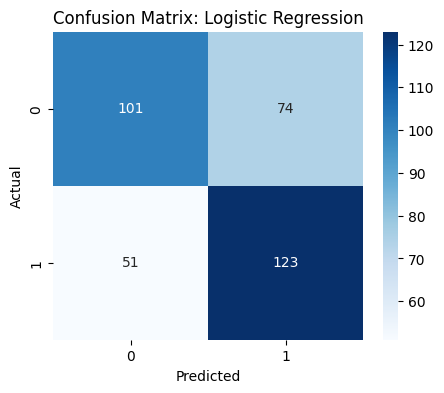

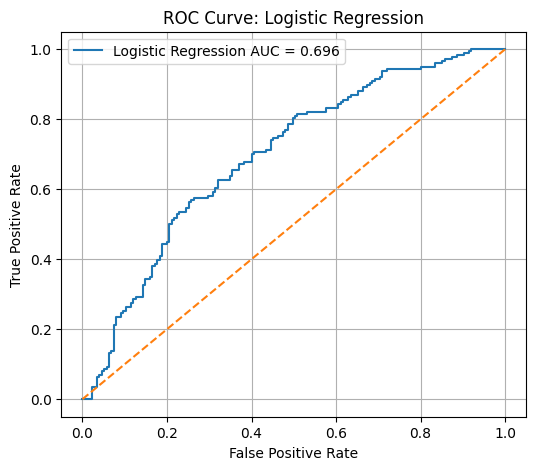


========== Random Forest ==========
Accuracy : 0.8968481375358166
Precision: 0.8833333333333333
Recall   : 0.9137931034482759
F1 Score : 0.8983050847457628


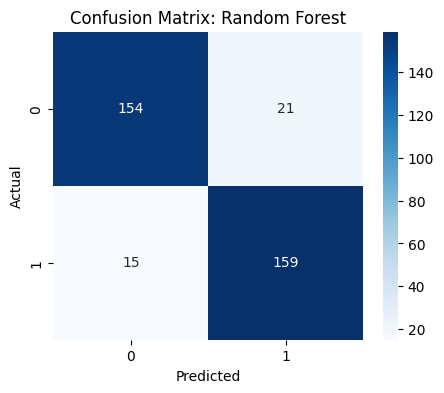

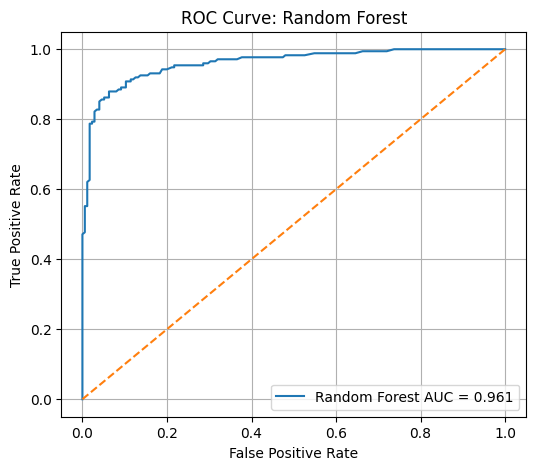


========== SVM (RBF Kernel) ==========
Accuracy : 0.6848137535816619
Precision: 0.6702127659574468
Recall   : 0.7241379310344828
F1 Score : 0.6961325966850829


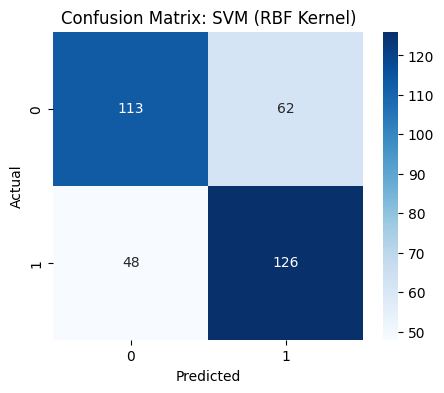

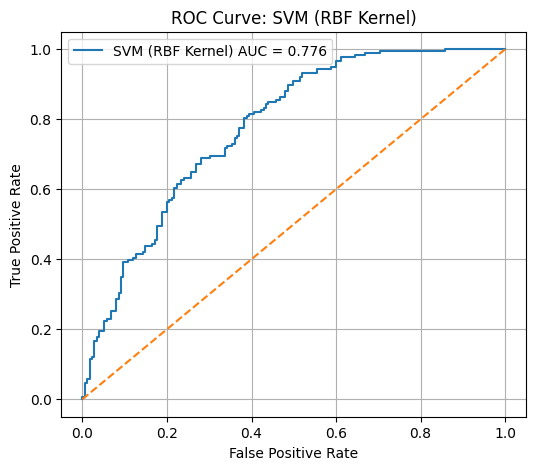

In [ ]:
# Call the each model
evaluate_model(log_model, X_test, y_test, "Logistic Regression")
evaluate_model(rf_model, X_test, y_test, "Random Forest")
evaluate_model(svm_model, X_test, y_test, "SVM (RBF Kernel)")

In [ ]:
# Best Model selection

from sklearn.metrics import f1_score

# Predict for all models
log_pred  = log_model.predict(X_test)
rf_pred   = rf_model.predict(X_test)
svm_pred  = svm_model.predict(X_test)

# Compute F1-score for each model
f1_log = f1_score(y_test, log_pred)
f1_rf  = f1_score(y_test, rf_pred)
f1_svm = f1_score(y_test, svm_pred)

print("F1-score (Logistic Regression):", f1_log)
print("F1-score (Random Forest)      :", f1_rf)
print("F1-score (SVM)                :", f1_svm)

# Select best model
model_scores = {
    "Logistic Regression": (log_model, f1_log),
    "Random Forest": (rf_model, f1_rf),
    "SVM": (svm_model, f1_svm)
}

best_model_name = max(model_scores, key=lambda x: model_scores[x][1])
best_model = model_scores[best_model_name][0]

print("\nBest Model Selected:", best_model_name)


F1-score (Logistic Regression): 0.6630727762803235
F1-score (Random Forest)      : 0.8983050847457628
F1-score (SVM)                : 0.6961325966850829

Best Model Selected: Random Forest


In [70]:
print(rf_model.feature_names_in_)
print((rf_model.feature_importances_) * 100)

['Age' 'MonthlyUsageHours' 'NumTransactions' 'SubscriptionType'
 'Complaints' 'Gender_Male']
[22.21640246 21.32216684 20.48499784  7.29090865 25.99405166  2.69147254]


In [ ]:
import joblib

# Save the best model
joblib.dump(best_model, "best_model.joblib")

print("Best model saved as best_model.joblib")

Best model saved as best_model.joblib


In [ ]:
X_resampled.head()

,Age,MonthlyUsageHours,NumTransactions,SubscriptionType,Complaints,Gender_Male
0,-0.109513,0.887380,-0.139901,-0.567216,1.292306,False
1,1.624098,-1.076027,0.609118,-0.567216,-0.855709,False
2,0.005066,1.554197,0.084805,-0.567216,-0.139704,True
3,-0.980432,-1.224209,1.133431,1.192971,0.576301,False
4,0.990564,-0.011306,-1.862645,-0.567216,1.650309,False


In [61]:
import joblib
# Save the scaler used during standardization
joblib.dump(scaler, "scaler.joblib")

# Save the exact column order after preprocessing
joblib.dump(columns, "columns.joblib")

print("Model, scaler, and columns saved successfully!")

Model, scaler, and columns saved successfully!


In [62]:
X_train.columns

Index(['Age', 'MonthlyUsageHours', 'NumTransactions', 'SubscriptionType',
       'Complaints', 'Gender_Male'],
      dtype='object')

In [63]:
X_train.head()

,Age,MonthlyUsageHours,NumTransactions,SubscriptionType,Complaints,Gender_Male
287,-0.276505,0.164994,1.582843,-0.567216,0.576301,False
346,-0.628468,0.313176,-0.589313,2.953158,-0.139704,False
358,0.075459,0.609539,-0.664215,1.192971,-0.139704,True
66,-1.050825,-0.983413,1.433039,2.953158,-1.929716,False
1351,0.354499,-0.180708,-1.488809,-0.567216,0.094675,True
